#### Model taken from:
- Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- Modelling and Control of Offshore Marine Pipeline during Pipelay. Gullik A. Jensen et al

M(q)q ̈ + C(q,q ̇)q ̇ + H(q,q ̇)q ̇ + f(q) + g(q) = τ

In [1]:
import numpy as np
import math
from scipy.integrate import odeint, ode, solve_ivp
from numpy.linalg import inv, pinv
from scipy.integrate import ode
from scipy.misc import derivative
import numdifftools as nd
import tqdm
import functools
from datetime import datetime
from scipy.optimize import fsolve

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

### Inputs

In [4]:
pipe_joint_length = 210 #100 # [m]
pipe_weight_per_unit_length = 96 #  (submerged) [kg/m]

q = [45, 20, 15, 5, 3, 2, 1, 0] # used for initial checks only but not in final solution 
l = [pipe_joint_length for i in range(len(q))]

# mn = 5.08976 * 10e7 # mass of the vessel, [kg]
# In = 5.041*10e7 # moment of inertia of the vessel, [kg*𝑚2]
# mn = 80048 # mass of the vessel, [kg]
# In = 50410 # moment of inertia of the vessel, [kg*𝑚2]

mn = 32219000 # mass of the vessel, [kg]
# mn = 5.08976 *1e7 # mass of the vessel, [kg]

In [5]:
# L - the hull length
# Xg - x-center of gravity

L = 169 # [m]
Xg = 78 # [m]
# L = 240 # [m]
# Xg = 120 # [m]

In [6]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [7]:
In = vessel_inertia_moment(mn,Xg,L)

In [8]:
In

253533324687.5

In [9]:
mi = [x*pipe_weight_per_unit_length for x in l] # mass of pipe element (submerged), [kg]

In [10]:
# for hydrodynamic damping matrix
Cd=[0.87,0.87,0.87,0.87,0.87,0.87,0.87,0.87, 1.6] # Drag coefficient
# Cd=0.82 # Drag coefficient

qw = 1025 # Water density [kg/m3]
d0 = 0.7610 # Outer diameter of pipe, [m]
dI= 0.69# Inner diameter of pipe, [m]

In [11]:
# for vector of spring forces in the pipe joints
# K = 1.4*10e11
E = 200*10e9 # modulus of elasticity of steel, [N/m^2]
EI = E*3.14/64*(d0**4-dI**4) # Bending stiffness [N*m^2]

K = EI#10e7 # depends on the unit bending stiffness of the pipe (EI), 
       # and the length li, of the link; from the Jensen thesis [N/m]

In [12]:
# for vector of control inputs
tau_qn = 250576 # tension in pipe at water level, [N] (check Jee sheets)
Fx_ = 5e5 # [N], from the Jensen thesis
# Fy=-100*1000 # [N],

In [13]:
# for solution
max_t = 50 #300  
dt = 0.1 #0.5
t=np.arange(0,max_t,dt)
# q0=[45, 0, 20, 0, 15, 0, 5, 0]

In [14]:
Awp = 1000 # the waterplane area of the vessel, [m^2]
# h=26.3 # water depth, [m]
h=400

# fip=1e9
fip=1e12

### System inertia matrix 

In [15]:
def alpha(i, q):
    return sum(q[:i+1])
    
def Jv(q, i, l):

    def Jv0(i, k, q, l):
        if k<i:
            tmp1=0
            for j in range(k, i):
                tmp1+=l[j]*math.sin(math.radians(alpha(j,q)))
            tmp1=-tmp1-0.5*l[i]*math.sin(math.radians(alpha(i,q)))  

            tmp2=0
            for j in range(k, i):
                tmp2+=l[j]*math.cos(math.radians(alpha(j,q)))
            tmp2=tmp2+0.5*l[i]*math.cos(math.radians(alpha(i,q))) 

            return np.array([tmp1, tmp2]).T

        elif k==i:
            return np.array([-0.5*l[i]*math.sin(math.radians(alpha(i,q))),
                    0.5*l[i]*math.cos(math.radians(alpha(i,q)))]).T
        else:
            return np.array([0, 0]).T
    
    ans=np.array([Jv0(i, k, q, l) for k in range(len(q))])
    
    return ans.T

def Jomega(i):

    def Jomega0(i,k):
        if k<=i:
            return 1
        return 0
    ans=np.array([Jomega0(i, k) for k in range(len(q))])
   
    return ans.reshape(len(q),1).T

In [16]:
def M(q, l, mn, In, mi):
    
    sum1 = mn * np.dot(Jv( q, len(q)-1, l).T, Jv(q, len(q)-1, l))
    
 
    sum2 = In * np.dot(Jomega(len(q)-1).T, Jomega(len(q)-1))
    
    sum3=0
    for i in range(len(q)-1):
        sum3+=mi[i]*np.dot(Jv(q, i, l).T, Jv( q,i, l))
      
    return sum1 + sum2 + sum3   

In [17]:
M(q, l, mn, In, mi)

array([[7.46252944e+13, 6.60738739e+13, 5.60792992e+13, 4.57902463e+13,
        3.55610669e+13, 2.54069843e+13, 1.53203340e+13, 5.27490107e+12],
       [6.60738739e+13, 5.89488680e+13, 5.02940578e+13, 4.11721808e+13,
        3.20338254e+13, 2.29205180e+13, 1.38395090e+13, 4.78139566e+12],
       [5.60792992e+13, 5.02940578e+13, 4.30647731e+13, 3.53192038e+13,
        2.75189421e+13, 1.97155873e+13, 1.19235215e+13, 4.14286634e+12],
       [4.57902463e+13, 4.11721808e+13, 3.53192038e+13, 2.89982710e+13,
        2.26165602e+13, 1.62224367e+13, 9.83095601e+12, 3.44548998e+12],
       [3.55610669e+13, 3.20338254e+13, 2.75189421e+13, 2.26165602e+13,
        1.76585968e+13, 1.26856035e+13, 7.71090248e+12, 2.73895283e+12],
       [2.54069843e+13, 2.29205180e+13, 1.97155873e+13, 1.62224367e+13,
        1.26856035e+13, 9.13546849e+12, 5.58209257e+12, 2.02949750e+12],
       [1.53203340e+13, 1.38395090e+13, 1.19235215e+13, 9.83095601e+12,
        7.71090248e+12, 5.58209257e+12, 3.45068586e+12, 1.

### Coriolis-centripetal matrix

In [18]:
# TODO - not sure about this formula 
def C(q, dq, l, mn, In, mi): #here
    ans = np.zeros((len(q),len(q)))              
    fun = lambda q: M(q, l, mn, In, mi)
    Dfun = nd.Gradient(fun) 
    
    dM_dq0, dM_dq1, dM_dq2, dM_dq3, dM_dq4, dM_dq5, dM_dq6, dM_dq7 = Dfun(q)
    diff = [dM_dq0, dM_dq1, dM_dq2, dM_dq3, dM_dq4, dM_dq5, dM_dq6, dM_dq7]
    
    def c(i,j,k):
        return 0.5 *(diff[k].item((i,j))+
                     diff[j].item((i,k))-
                     diff[i].item((j,k)))
    
    for i in range(len(q)):
        for j in range(len(q)):
            for k in range(len(q)):
                ans[i][j]+=c(i,j,k)*np.radians(dq[k])
    return ans                

In [19]:
dq=[1,1,0.5,1,4,1,2,3]
C(q, dq, l, mn, In, mi)

array([[ 6.10180812e-06,  6.91680572e+09,  1.10419391e+10,
         1.20496565e+10,  1.17613143e+10,  9.71765018e+09,
         6.65340876e+09,  2.54693044e+09],
       [-1.38336114e+10, -8.72702841e+08,  3.54951444e+09,
         5.11737665e+09,  5.59578778e+09,  4.95642769e+09,
         3.50044944e+09,  1.34047530e+09],
       [-2.20838782e+10, -9.49432450e+09, -1.69625587e+09,
         2.36701522e+08,  1.27145025e+09,  1.60602538e+09,
         1.29435025e+09,  5.10384879e+08],
       [-2.40993130e+10, -1.22566190e+10, -4.85172981e+09,
        -1.83102835e+09, -6.35607551e+08,  7.60354576e+07,
         2.72153450e+08,  1.28426569e+08],
       [-2.35226287e+10, -1.27952122e+10, -6.05792813e+09,
        -3.21680133e+09, -1.72056939e+09, -8.44442860e+08,
        -3.55700478e+08, -1.03437695e+08],
       [-1.94353004e+10, -1.10730276e+10, -5.77547384e+09,
        -3.46224207e+09, -2.17586840e+09, -1.47239257e+09,
        -8.05998291e+08, -2.64832820e+08],
       [-1.33068175e+10, -7.701567

### Hydrodynamic damping matrix

In [20]:
def R_I_Bi(i, q):
    return np.array([[math.cos(math.radians(alpha(i,q))), -math.sin(math.radians(alpha(i,q)))],
                    [math.sin(math.radians(alpha(i,q))), math.cos(math.radians(alpha(i,q)))]])

In [21]:
I_=np.array([[0,0],
             [0,1]])

In [22]:
def Pi(i,q):
    return np.dot(np.dot(R_I_Bi(i, q),I_),R_I_Bi(i, q).T)

In [23]:
# TODO - not sure about this formula 
def mod_Vni(i,q,dq): #here
    return np.linalg.norm(np.dot(np.dot(Pi(i,q),Jv( q,i, l)), np.radians(dq)))

In [24]:
def gamma(i):
    return 0.5*Cd[i]*qw*d0*l[i]

In [25]:
def H(q,dq,l):
    ans=np.zeros((len(q), len(q)))
    
    for j in range(len(q)):
        ans+=gamma(j)*mod_Vni(j,q,dq)*np.dot(np.dot(Jv(q,j,l).T,Pi(j,q)),Jv( q,j, l))
    return ans    

In [26]:
H(q,[0,0,0,0.1,1,2,3,1],l)

array([[1.20967978e+13, 1.08132581e+13, 9.15481049e+12, 7.34485292e+12,
        5.51245261e+12, 3.68913938e+12, 1.95985191e+12, 5.67700430e+11],
       [1.08132581e+13, 9.66824088e+12, 8.18866652e+12, 6.57385892e+12,
        4.93888730e+12, 3.31082408e+12, 1.76307712e+12, 5.11906222e+11],
       [9.15481049e+12, 8.18866652e+12, 6.94007802e+12, 5.57727967e+12,
        4.19727564e+12, 2.82147124e+12, 1.50847714e+12, 4.39716057e+11],
       [7.34485292e+12, 6.57385892e+12, 5.57727967e+12, 4.48943017e+12,
        3.38761181e+12, 2.28709905e+12, 1.23041315e+12, 3.60872825e+11],
       [5.51245261e+12, 4.93888730e+12, 4.19727564e+12, 3.38761181e+12,
        2.56740313e+12, 1.74573185e+12, 9.48696485e+11, 2.80993903e+11],
       [3.68913938e+12, 3.31082408e+12, 2.82147124e+12, 2.28709905e+12,
        1.74573185e+12, 1.20214320e+12, 6.65816260e+11, 2.00785060e+11],
       [1.95985191e+12, 1.76307712e+12, 1.50847714e+12, 1.23041315e+12,
        9.48696485e+11, 6.65816260e+11, 3.82590969e+11, 1.

### Vector of spring forces in the pipe joints

In [27]:
def f(q,k):
    ans=np.array([k*q[i] for i in range(len(q))])
    return ans.reshape(len(q),1)

### Vector of gravitational/buoyancy forces

In [28]:
def x(q,i,l):
    tmp1=0
    for j in range(i):
        tmp1+=l[j]*math.cos(math.radians(alpha(j,q)))
    tmp1+=0.5*l[i]*math.cos(math.radians(alpha(i,q)))
    return tmp1

In [29]:
def y(q,i,l):
    tmp1=0
    for j in range(i):
        tmp1+=l[j]*math.sin(math.radians(alpha(j,q)))
    tmp1+=0.5*l[i]*math.sin(math.radians(alpha(i,q)))
    return tmp1

In [30]:
G=np.array([0,-9.81]).T

def ggi(i,G):
    return mi[i]*G
   
    
def gbi(G,l,i):
    return -3.14*l[i]*(d0**2/4)*qw*G 

def gt(q,fip, i): #here
    return -fip*math.radians(alpha(i, q))


In [31]:
def g(q):
    sum_=0
    for i in range(len(q)-1):
        sum_+=np.dot(Jv( q,i, l).T,ggi(i,G)+gbi(G,l,i)) 
        
#     print(sum_)
    tmp = -qw*Awp*(y(q,len(q)-1,l)-h)*G 
#     tmp=G 
#     print(np.dot(Jv(q,len(q)-1, l).T, tmp).shape,
#           np.dot(Jomega(len(q)-1).T, gt(q, fip, len(q)-1)).shape)
#     print(np.dot(Jv(q,len(q)-1, l).T, tmp))   
    sum_ += np.dot(Jv(q,len(q)-1, l).T, tmp) - \
        np.dot(Jomega(len(q)-1).T, gt(q, fip, len(q)-1)).reshape(len(q),) 
   
    return sum_.reshape(len(q),1)   

In [32]:
g(q)

array([[4.80909343e+12],
       [3.18136786e+12],
       [2.20858873e+12],
       [1.80891462e+12],
       [1.60832817e+12],
       [1.52801357e+12],
       [1.52801357e+12],
       [1.56817140e+12]])

### Vector of control inputs

In [33]:
# Assume that the stinger is shorter than the link length li for any link i
def tau_q(q,tau_qn): 
    ans= np.array([0 for i in range(len(q))]).reshape(len(q),1)
    ans[-1] = tau_qn
    return ans
# tau_q - control forces from the stinger 

In [34]:
def Fx(q,kp, x_ref = 0):
    return -kp*(x(q,len(q)-1,l)-x_ref)    

In [35]:
F=np.array([Fx_,0]).reshape(2,1) # actuates the vessel in the surge direction in frame Bn
# F=np.array([0,Fy]).reshape(2,1)
def tau_t(q, F):
    return np.dot(Jv(q,len(q)-1, l).T, F) # the thruster forces

In [36]:
tau_q_wave=9e6 # (taken from article on forces to semi-submersible platform),[N]
# this function purly my invention
def tau_wave(q, tau_q_wave):
    ans= np.array([0 for i in range(len(q))]).reshape(len(q),1)
    ans[-1] = tau_q_wave
    return ans

In [37]:
def tau(q, tau_qn, F, tau_q_wave):
#     return tau_q(q,tau_qn) + tau_t(q, F) + tau_wave(q, tau_q_wave)
#     return tau_t(q, F) + tau_wave(q, tau_q_wave)
#     return  tau_t(q, F)
    return tau_t(q, F) + tau_wave(q, tau_q_wave)

### Static solution

In [38]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [39]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]

In [40]:
lift_off_slope = 30.6 # from Jee catenary sheet, [deg]

In [41]:
# Fx_=250000 # [N]

In [42]:
horizontal_length =(Fx_/Ws)*math.asinh(math.tan(math.radians(lift_off_slope)))

In [43]:
horizontal_length

298.07757012846395

In [44]:
number_of_nodes=8

In [45]:
delta_x=horizontal_length/number_of_nodes

In [46]:
x0=[i*delta_x for i in range(number_of_nodes+1)]
y0=[]
for i in range(len(x0)):
    y0.append(catenary(x0[i],Ws,Fx_))

In [47]:
x0

[0.0,
 37.25969626605799,
 74.51939253211599,
 111.77908879817397,
 149.03878506423197,
 186.29848133028997,
 223.55817759634795,
 260.817873862406,
 298.07757012846395]

In [48]:
q=[]
l_=[]
deg_=[0]
for i in range(len(x0)-1):
    l_.append(math.sqrt((x0[i+1]-x0[i])**2+(y0[i+1]-y0[i])**2))
    deg =math.degrees(math.atan((y0[i+1]-y0[i])/(x0[i+1]-x0[i])))
    q.append(deg-deg_[-1]) 
    deg_.append(deg)

In [49]:
q

[2.010490959753564,
 4.011100251208111,
 3.9816966661796904,
 3.9334811737284507,
 3.8675911659067204,
 3.785527622786102,
 3.6890751945023545,
 3.580213703409523]

In [50]:
l_

[37.282646713773254,
 37.466419691242635,
 37.83487002986847,
 38.38981101108427,
 39.133973858410755,
 40.0710213456062,
 41.205566021392734,
 42.54319312514459]

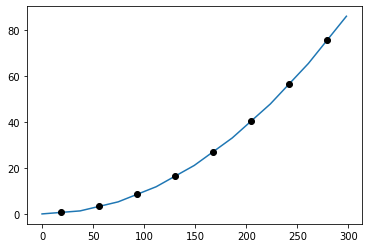

In [51]:
plt.plot(x0, y0)
plt.plot(x(q,0,l_),y(q,0,l_), 'o', color='black')
plt.plot(x(q,1,l_),y(q,1,l_), 'o', color='black')
plt.plot(x(q,2,l_),y(q,2,l_), 'o', color='black')
plt.plot(x(q,3,l_),y(q,3,l_), 'o', color='black')
plt.plot(x(q,4,l_),y(q,4,l_), 'o', color='black')
plt.plot(x(q,5,l_),y(q,5,l_), 'o', color='black')
plt.plot(x(q,6,l_),y(q,6,l_), 'o', color='black')
plt.plot(x(q,7,l_),y(q,7,l_), 'o', color='black')
plt.show()

In [52]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

In [53]:
q0

[2.010490959753564,
 0,
 4.011100251208111,
 0,
 3.9816966661796904,
 0,
 3.9334811737284507,
 0,
 3.8675911659067204,
 0,
 3.785527622786102,
 0,
 3.6890751945023545,
 0,
 3.580213703409523,
 0]

In [54]:
def static_func(q):
    ans=  f(q, K) + g(q) - tau(q, tau_qn, F, 0)
    return ans.reshape((len(q),))

In [55]:
root = fsolve(static_func, np.array(q))

In [56]:
root

array([ 7.94686038,  5.82447771,  3.72955336,  1.65881308, -0.40603329,
       -2.49019398, -4.61798782, -6.80437241])

In [57]:
q=list(root)

In [58]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

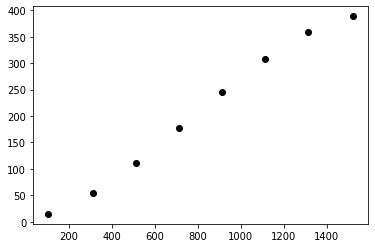

In [59]:
plt.plot(x(q,0,l),y(q,0,l), 'o', color='black')
plt.plot(x(q,1,l),y(q,1,l), 'o', color='black')
plt.plot(x(q,2,l),y(q,2,l), 'o', color='black')
plt.plot(x(q,3,l),y(q,3,l), 'o', color='black')
plt.plot(x(q,4,l),y(q,4,l), 'o', color='black')
plt.plot(x(q,5,l),y(q,5,l), 'o', color='black')
plt.plot(x(q,6,l),y(q,6,l), 'o', color='black')
plt.plot(x(q,7,l),y(q,7,l), 'o', color='black')
plt.show()

In [60]:
q

[7.946860384465539,
 5.8244777108943415,
 3.7295533616645873,
 1.6588130785165613,
 -0.40603329061462373,
 -2.4901939772276687,
 -4.617987820133675,
 -6.804372410565416]

In [61]:
q0

[7.946860384465539,
 0,
 5.8244777108943415,
 0,
 3.7295533616645873,
 0,
 1.6588130785165613,
 0,
 -0.40603329061462373,
 0,
 -2.4901939772276687,
 0,
 -4.617987820133675,
 0,
 -6.804372410565416,
 0]

In [62]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, [q])))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, [q])))

add6=functools.partial(g)
add6__g =np.array(list(map(add6, [q])))

print(datetime.now() - startTime)

0:00:00.015898


In [63]:
tmp__1=pinv(add1__Jv.transpose(0, 2, 1))

tmp__2= add5__f + add6__g

In [64]:
tmp__=np.matmul(tmp__1, tmp__2)

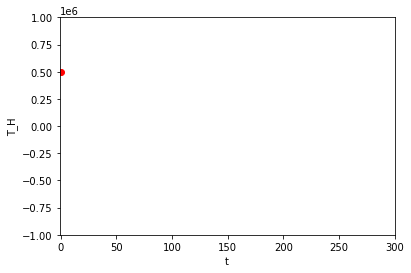

In [65]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'o', color='red')
plt.xlim([-1, 300])
plt.ylim([-1000000, 1000000])
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

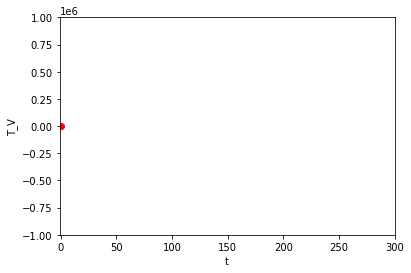

In [66]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'o', color='red')
plt.xlim([-1, 300])
plt.ylim([-1000000, 1000000])
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [67]:
max(tmp__[:,0]), max(tmp__[:,1])

(array([499999.96397333]), array([-0.01331804]))

### Dynamic solution 

In [68]:
def manipulator(Q, t, q):
    q0,dq0,q1,dq1,q2,dq2,q3,dq3,q4,dq4,q5,dq5,q6,dq6,q7,dq7 = Q
    QI=np.array([q0,q1,q2,q3,q4,q5,q6,q7]).reshape(len(q),1)
    dQ=np.array([dq0,dq1,dq2,dq3,dq4,dq5,dq6,dq7]).reshape(len(q),1)
    ddq0, ddq1, ddq2, ddq3, ddq4, ddq5, ddq6, ddq7 = np.dot(
                                inv(M(QI, l, mn, In, mi)),
                                 - np.dot(H(QI,dQ,l),dQ).reshape(len(QI),1)
                                 - np.dot(C(QI,dQ, l, mn, In, mi),dQ).reshape(len(QI),1)  
                                 - f(QI, K) 
                                 - g(QI)
                                 + tau(QI, tau_qn, F, tau_q_wave) 
                                )
    return [dq0,ddq0,dq1,ddq1,dq2,ddq2,dq3,ddq3,dq4,ddq4,dq5,ddq5,dq6,ddq6,dq7,ddq7]

In [69]:
startTime1 = datetime.now()

us=odeint(manipulator,q0,t, args=(q,))

print(datetime.now() - startTime1)

14:57:26.492453


In [70]:
# us_=us.sol(t).T
us_=us

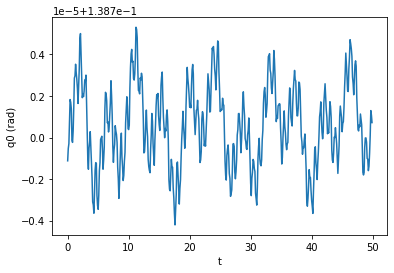

In [71]:
plt.plot(t, np.radians(us_[:,0]),'-')
plt.xlabel('t')
plt.ylabel('q0 (rad)')
plt.show()

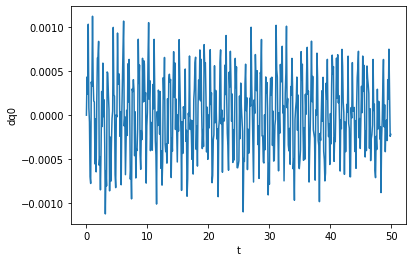

In [72]:
plt.plot(t, us_[:,1],'-')
plt.xlabel('t')
plt.ylabel('dq0')
plt.show()

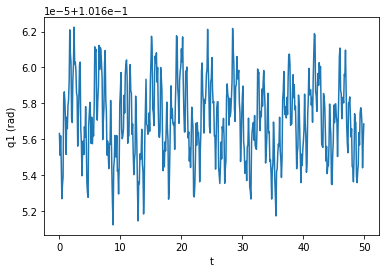

In [73]:
plt.plot(t, np.radians(us_[:,2]),'-')
plt.xlabel('t')
plt.ylabel('q1 (rad)')
plt.show()

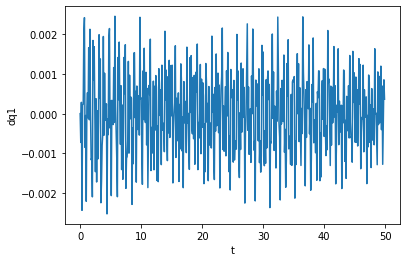

In [74]:
plt.plot(t, us_[:,3],'-')
plt.xlabel('t')
plt.ylabel('dq1')
plt.show()

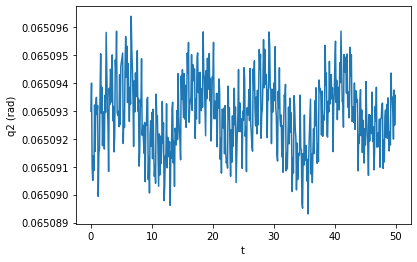

In [75]:
plt.plot(t, np.radians(us_[:,4]),'-')
plt.xlabel('t')
plt.ylabel('q2 (rad)')
plt.show()

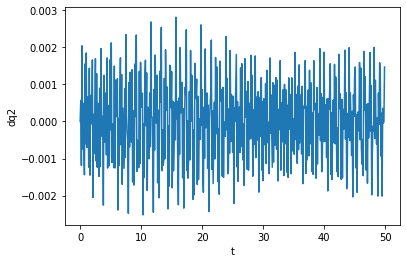

In [76]:
plt.plot(t, us_[:,5],'-')
plt.xlabel('t')
plt.ylabel('dq2')
plt.show()

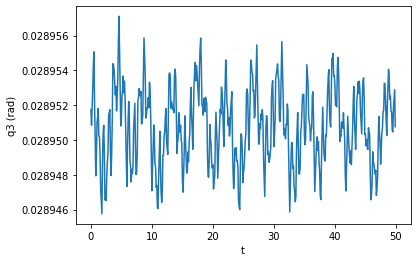

In [77]:
plt.plot(t, np.radians(us_[:,6]),'-')
plt.xlabel('t')
plt.ylabel('q3 (rad)')
plt.show()

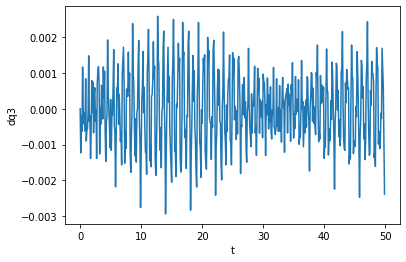

In [78]:
plt.plot(t, us_[:,7],'-')
plt.xlabel('t')
plt.ylabel('dq3')
plt.show()

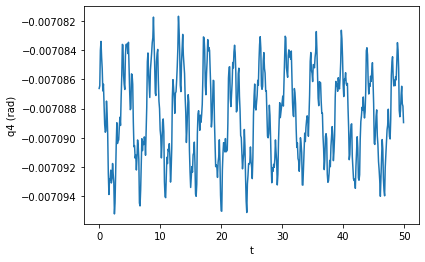

In [79]:
plt.plot(t, np.radians(us_[:,8]),'-')
plt.xlabel('t')
plt.ylabel('q4 (rad)')
plt.show()

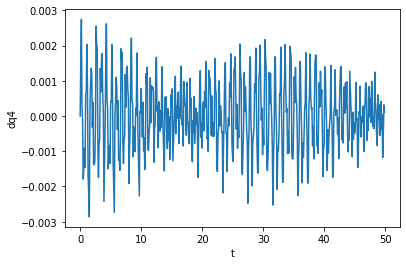

In [80]:
plt.plot(t, us_[:,9],'-')
plt.xlabel('t')
plt.ylabel('dq4')
plt.show()

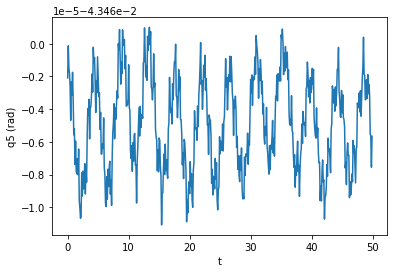

In [81]:
plt.plot(t, np.radians(us_[:,10]),'-')
plt.xlabel('t')
plt.ylabel('q5 (rad)')
plt.show()

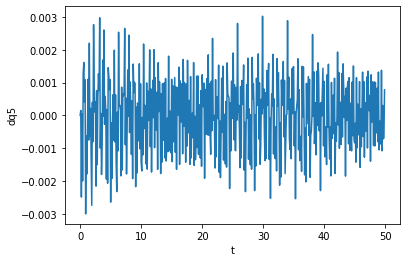

In [82]:
plt.plot(t, us_[:,11],'-')
plt.xlabel('t')
plt.ylabel('dq5')
plt.show()

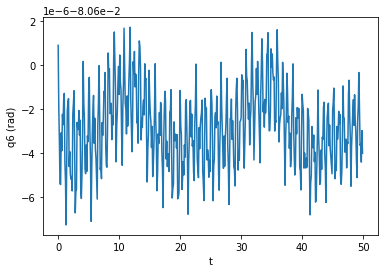

In [83]:
plt.plot(t, np.radians(us_[:,12]),'-')
plt.xlabel('t')
plt.ylabel('q6 (rad)')
plt.show()

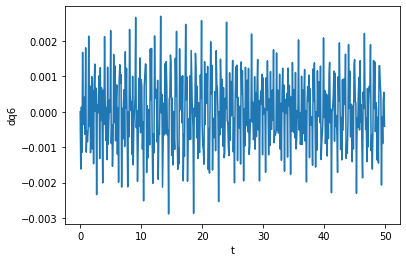

In [84]:
plt.plot(t, us_[:,13],'-')
plt.xlabel('t')
plt.ylabel('dq6')
plt.show()

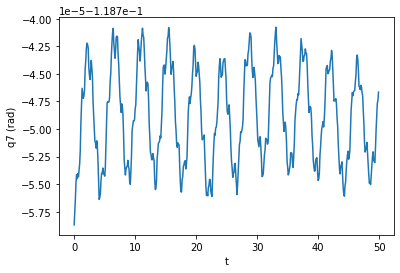

In [85]:
plt.plot(t, np.radians(us_[:,14]),'-')
plt.xlabel('t')
plt.ylabel('q7 (rad)')
plt.show()

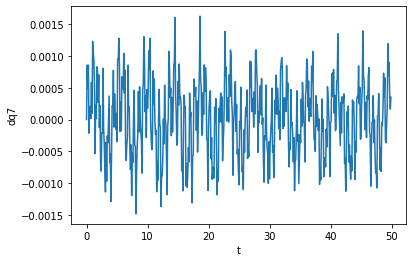

In [86]:
plt.plot(t, us_[:,15],'-')
plt.xlabel('t')
plt.ylabel('dq7')
plt.show()

In [87]:
X0=[x(us_[i,[0,2,4,6,8,10,12,14]],0,l) for i in range(len(us_))]
Y0=[y(us_[i,[0,2,4,6,8,10,12,14]],0,l) for i in range(len(us_))]
X1=[x(us_[i,[0,2,4,6,8,10,12,14]],1,l) for i in range(len(us_))]
Y1=[y(us_[i,[0,2,4,6,8,10,12,14]],1,l) for i in range(len(us_))]
X2=[x(us_[i,[0,2,4,6,8,10,12,14]],2,l) for i in range(len(us_))]
Y2=[y(us_[i,[0,2,4,6,8,10,12,14]],2,l) for i in range(len(us_))]
X3=[x(us_[i,[0,2,4,6,8,10,12,14]],3,l) for i in range(len(us_))]
Y3=[y(us_[i,[0,2,4,6,8,10,12,14]],3,l) for i in range(len(us_))]
X4=[x(us_[i,[0,2,4,6,8,10,12,14]],4,l) for i in range(len(us_))]
Y4=[y(us_[i,[0,2,4,6,8,10,12,14]],4,l) for i in range(len(us_))]
X5=[x(us_[i,[0,2,4,6,8,10,12,14]],5,l) for i in range(len(us_))]
Y5=[y(us_[i,[0,2,4,6,8,10,12,14]],5,l) for i in range(len(us_))]
X6=[x(us_[i,[0,2,4,6,8,10,12,14]],6,l) for i in range(len(us_))]
Y6=[y(us_[i,[0,2,4,6,8,10,12,14]],6,l) for i in range(len(us_))]
X7=[x(us_[i,[0,2,4,6,8,10,12,14]],7,l) for i in range(len(us_))]
Y7=[y(us_[i,[0,2,4,6,8,10,12,14]],7,l) for i in range(len(us_))]

In [88]:
X0_=[x(us_[i,[0,2,4,6,8,10,12,14]],0,l) for i in range(1)]
Y0_=[y(us_[i,[0,2,4,6,8,10,12,14]],0,l) for i in range(1)]
X1_=[x(us_[i,[0,2,4,6,8,10,12,14]],1,l) for i in range(1)]
Y1_=[y(us_[i,[0,2,4,6,8,10,12,14]],1,l) for i in range(1)]
X2_=[x(us_[i,[0,2,4,6,8,10,12,14]],2,l) for i in range(1)]
Y2_=[y(us_[i,[0,2,4,6,8,10,12,14]],2,l) for i in range(1)]
X3_=[x(us_[i,[0,2,4,6,8,10,12,14]],3,l) for i in range(1)]
Y3_=[y(us_[i,[0,2,4,6,8,10,12,14]],3,l) for i in range(1)]
X4_=[x(us_[i,[0,2,4,6,8,10,12,14]],4,l) for i in range(1)]
Y4_=[y(us_[i,[0,2,4,6,8,10,12,14]],4,l) for i in range(1)]
X5_=[x(us_[i,[0,2,4,6,8,10,12,14]],5,l) for i in range(1)]
Y5_=[y(us_[i,[0,2,4,6,8,10,12,14]],5,l) for i in range(1)]
X6_=[x(us_[i,[0,2,4,6,8,10,12,14]],6,l) for i in range(1)]
Y6_=[y(us_[i,[0,2,4,6,8,10,12,14]],6,l) for i in range(1)]
X7_=[x(us_[i,[0,2,4,6,8,10,12,14]],7,l) for i in range(1)]
Y7_=[y(us_[i,[0,2,4,6,8,10,12,14]],7,l) for i in range(1)]

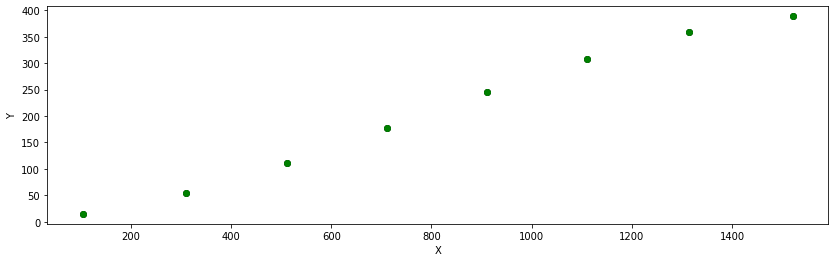

In [89]:
plt.figure(figsize=(14,4))
plt.plot(X0_,Y0_, 'o', color='black')
plt.plot(X1_,Y1_, 'o', color='black')
plt.plot(X2_,Y2_, 'o', color='black')
plt.plot(X3_,Y3_, 'o', color='black')
plt.plot(X4_,Y4_, 'o', color='black')
plt.plot(X5_,Y5_, 'o', color='black')
plt.plot(X6_,Y6_, 'o', color='black')
plt.plot(X7_,Y7_, 'o', color='black')


# dynamic
plt.plot(X0,Y0,'b')
plt.plot(X1,Y1,'y')
plt.plot(X2,Y2,'g')
plt.plot(X3,Y3,'r')
plt.plot(X4,Y4,'b')
plt.plot(X5,Y5,'y')
plt.plot(X6,Y6,'g')
plt.plot(X7,Y7,'r')


plt.plot(x(us_[-1,[0,2,4,6,8,10,12,14]],0,l),y(us_[-1,[0,2,4,6,8,10,12,14]],0,l), 'o', color='green')
plt.plot(x(us_[-1,[0,2,4,6,8,10,12,14]],1,l),y(us_[-1,[0,2,4,6,8,10,12,14]],1,l), 'o', color='green')
plt.plot(x(us_[-1,[0,2,4,6,8,10,12,14]],2,l),y(us_[-1,[0,2,4,6,8,10,12,14]],2,l), 'o', color='green')
plt.plot(x(us_[-1,[0,2,4,6,8,10,12,14]],3,l),y(us_[-1,[0,2,4,6,8,10,12,14]],3,l), 'o', color='green')
plt.plot(x(us_[-1,[0,2,4,6,8,10,12,14]],4,l),y(us_[-1,[0,2,4,6,8,10,12,14]],4,l), 'o', color='green')
plt.plot(x(us_[-1,[0,2,4,6,8,10,12,14]],5,l),y(us_[-1,[0,2,4,6,8,10,12,14]],5,l), 'o', color='green')
plt.plot(x(us_[-1,[0,2,4,6,8,10,12,14]],6,l),y(us_[-1,[0,2,4,6,8,10,12,14]],6,l), 'o', color='green')
plt.plot(x(us_[-1,[0,2,4,6,8,10,12,14]],7,l),y(us_[-1,[0,2,4,6,8,10,12,14]],7,l), 'o', color='green')
# plt.plot(x0, y0)
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

In [90]:
us_[0,0]

7.946860384465539

In [91]:
us_[0,2]

5.8244777108943415

In [92]:
us_[0,4]

3.7295533616645873

In [93]:
us_[0,6]

1.6588130785165613

In [94]:
us_[0,8]

-0.40603329061462373

In [95]:
us_[0,10]

-2.4901939772276687

In [96]:
us_[0,12]

-4.617987820133675

In [97]:
us_[0,14]

-6.804372410565416

In [98]:
us_[0,0]+us_[0,2]+us_[0,4]+us_[0,6]+us_[0,8]+us_[0,10]+us_[0,12]+us_[0,14]

4.841117036999646

### Pipe-tip tension

In [99]:
coordinates=us[:,[0,2,4,6,8,10,12,14]]
velocities=us[:,[1,3,5,7,9,11,13,15]]

In [100]:
velocities.shape

(500, 8)

In [101]:
velocities_0=velocities[:-1]
velocities_1=velocities[1:]

In [102]:
startTime1 = datetime.now()

add4=functools.partial(C, l=l, mn=mn, In=In, mi=mi)
add4__C =np.array(list(map(add4, coordinates, velocities)))

print(datetime.now() - startTime1)

0:18:48.983675


In [103]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, coordinates)))

add2=functools.partial(M, l=l, mn=mn, In=In, mi=mi)
add2__M =np.array(list(map(add2, coordinates)))

add3=functools.partial(H, l=l)
add3__H =np.array(list(map(add3, coordinates, velocities)))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, coordinates)))

add6=functools.partial(g)
add6__g =np.array(list(map(add6, coordinates)))

print(datetime.now() - startTime)

0:00:11.812100


In [104]:
velocities_1.shape

(499, 8)

In [106]:
tmp__1=pinv(add1__Jv[:-1].transpose(0, 2, 1))

tmp__2=np.matmul(add2__M[:-1], ((velocities_1.reshape(499,8,1) - 
                              velocities_0.reshape(499,8,1))/dt))\
            + np.matmul(add3__H[:-1],velocities[:-1].reshape(499,8,1)) \
            + np.matmul(add4__C[:-1],velocities[:-1].reshape(499,8,1)) \
            + add5__f[:-1] \
            + add6__g[:-1]

In [107]:
tmp__=np.matmul(tmp__1, tmp__2)

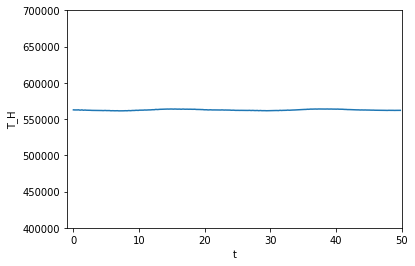

In [108]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'-')
plt.xlim([-1, 50])
plt.ylim([400000, 700000])
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

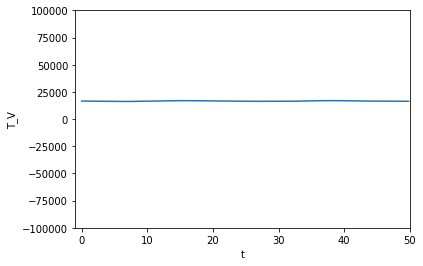

In [109]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'-')
plt.xlim([-1, 50])
plt.ylim([-100000, 100000])
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [ ]:
max(tmp__[:,0]), max(tmp__[:,1])